In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
df = pd.read_csv('./object-dataset/labels.csv', 
                 delim_whitespace=True,
                 names=["img", "xmin", "ymin", "xmax", "ymax", "occluded", "label", "attribute"]
                )
df.head()

,img,xmin,ymin,xmax,ymax,occluded,label,attribute
0,1478019952686311006.jpg,950,574,1004,620,0,car,NaN
1,1478019952686311006.jpg,1748,482,1818,744,0,pedestrian,NaN
2,1478019953180167674.jpg,872,586,926,632,0,car,NaN
3,1478019953689774621.jpg,686,566,728,618,1,truck,NaN
4,1478019953689774621.jpg,716,578,764,622,0,car,NaN


In [3]:
df["img"] = "./object-dataset/" + df["img"]
df.head()

,img,xmin,ymin,xmax,ymax,occluded,label,attribute
0,./object-dataset/1478019952686311006.jpg,950,574,1004,620,0,car,NaN
1,./object-dataset/1478019952686311006.jpg,1748,482,1818,744,0,pedestrian,NaN
2,./object-dataset/1478019953180167674.jpg,872,586,926,632,0,car,NaN
3,./object-dataset/1478019953689774621.jpg,686,566,728,618,1,truck,NaN
4,./object-dataset/1478019953689774621.jpg,716,578,764,622,0,car,NaN


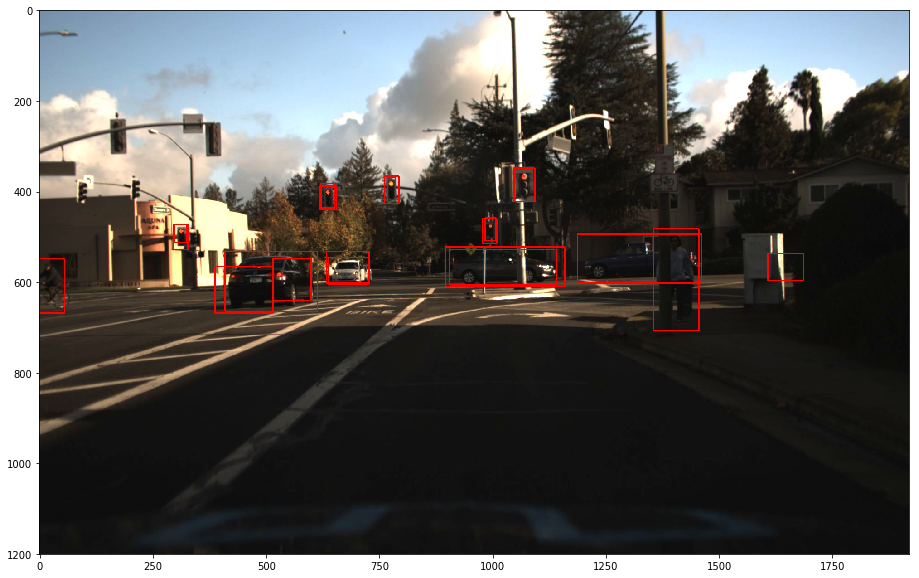

In [4]:
def get_boxes(img_path, df):
    boxes = []
    subset = df[df["img"] == img_path]
    for index, row in subset.iterrows():
        boxes.append(((row["xmin"], row["ymin"]), (row["xmax"], row["ymax"])))
    return boxes

def show_img(row, df): 
#     print(row["label"])
    img_path = row["img"]
    img = mpimg.imread(img_path)
    boxes = get_boxes(img_path, df)
    for box in boxes:
        img = cv2.rectangle(img, box[0], box[1], (255,0,0), 2)
    plt.figure(figsize=(20,10))
    plt.imshow(img)

# row = df.iloc[97]  #97 & 98
show_img(df.iloc[293], df)

In [5]:
dfcar = df[df["label"]=="car"].reset_index(drop=True)

dfcar.head()

,img,xmin,ymin,xmax,ymax,occluded,label,attribute
0,./object-dataset/1478019952686311006.jpg,950,574,1004,620,0,car,NaN
1,./object-dataset/1478019953180167674.jpg,872,586,926,632,0,car,NaN
2,./object-dataset/1478019953689774621.jpg,716,578,764,622,0,car,NaN
3,./object-dataset/1478019953689774621.jpg,826,580,880,626,0,car,NaN
4,./object-dataset/1478019953689774621.jpg,1540,488,1680,608,1,car,NaN


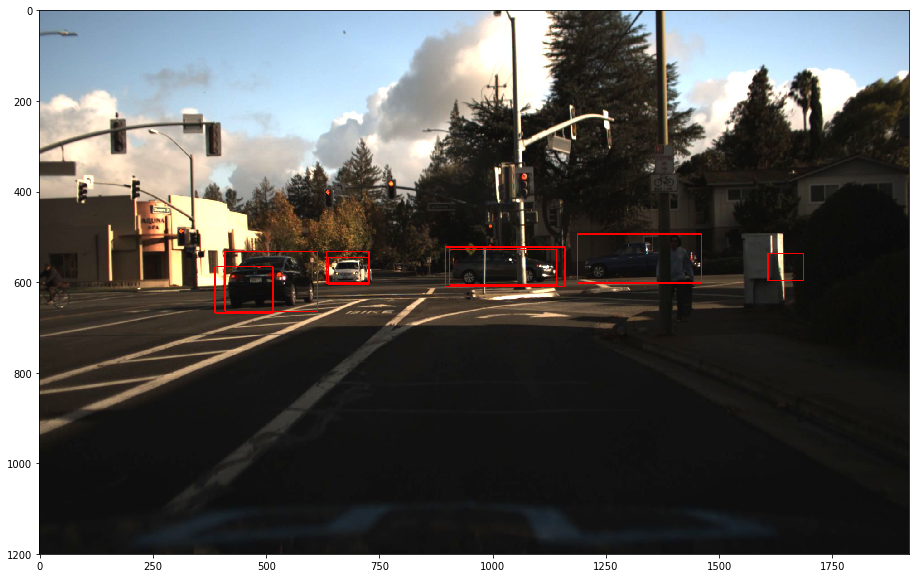

In [6]:
show_img(dfcar.iloc[171], dfcar)

In [7]:
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Activation
from keras.layers import Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import ThresholdedReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

Using TensorFlow backend.


In [117]:
#appromximate dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def conv2D(inputs, kernels=16, kernelSize=(3,3), name=None, padding='same'):
    conv = Convolution2D(kernels, kernelSize, padding=padding, name=name)(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv


def getModel():
    inputs = Input((None, None, 3))
    
    conv1 = conv2D(inputs, kernels=32, name='conv1_1')
    conv1 = conv2D(conv1, kernels=32, name='conv1_2')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv2D(pool1, kernels=64, name='conv2_1')
    conv2 = conv2D(conv2, kernels=64, name='conv2_2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv2D(pool2, kernels=128, name='conv3_1')
    conv3 = conv2D(conv3, kernels=128, name='conv3_2')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv2D(pool3, kernels=256, name='conv4_1')
    conv4 = conv2D(conv4, kernels=256, name='conv4_2')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv2D(pool4, kernels=512, name='conv5_1')
    conv5 = conv2D(conv5, kernels=512, name='conv5_2')
#     pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
#     conv6 = Convolution2D(1024, (3, 3), activation='relu', padding='same')(pool5)
#     conv6 = Convolution2D(1024, (3, 3), activation='relu', padding='same')(conv6)
#     pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    up4 = Concatenate()([UpSampling2D(size=(2,2))(conv5), conv4])
    upconv4 = conv2D(up4, kernels=256, name='upconv4_1')
    upconv4 = conv2D(upconv4, kernels=256, name='upconv4_2')
    
    up3 = Concatenate()([UpSampling2D(size=(2,2))(upconv4), conv3])
    upconv3 = conv2D(up3, kernels=128, name='upconv3_1')
    upconv3 = conv2D(upconv3, kernels=128, name='upconv3_2')
    
    up2 = Concatenate()([UpSampling2D(size=(2,2))(upconv3), conv2])
    upconv2 = conv2D(up2, kernels=64, name='upconv2_1')
    upconv2 = conv2D(upconv2, kernels=64, name='upconv2_2')
    
    up1 = Concatenate()([UpSampling2D(size=(2,2))(upconv2), conv1])
    upconv1 = conv2D(up1, kernels=32, name='upconv1_1')
    upconv1 = conv2D(upconv1, kernels=32, name='upconv1_2')
    
    upconv1 = Convolution2D(1, (1, 1), activation='sigmoid')(upconv1)
#     upconv1 = Convolution2D(1, (1, 1))(upconv2)
    upconv1 = ThresholdedReLU(theta=0.90)(upconv1)
    
    
    adam = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
    model = Model(inputs=inputs, outputs=upconv1)
    
    model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
    return model


model = getModel()
model.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_55 (Batc (None, None, None, 32)    128       
_________________________________________________________________
activation_55 (Activation)   (None, None, None, 32)    0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_56 (Batc (None, None, None, 32)    128       
_________________________________________________________________
activation_56 (Activation)   (None, None, None, 32)    0         
__________

(1200, 1920, 3)


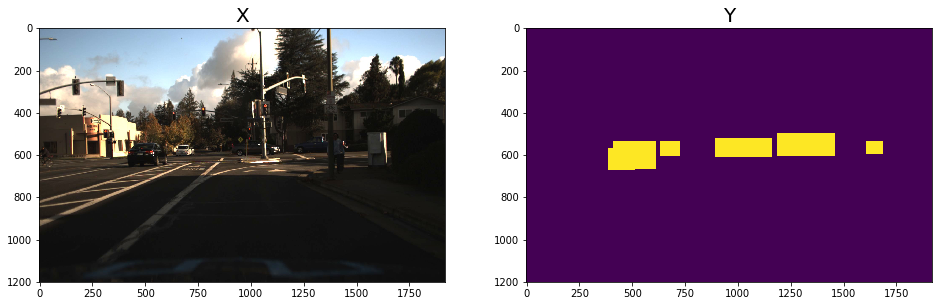

In [9]:
def plot_xy(x, y):
    f, ax = plt.subplots(1, 2, figsize=(16,10))
    ax[0].imshow(x)
    ax[0].set_title('X', fontsize=20)
    ax[1].imshow(y)
    ax[1].set_title('Y', fontsize=20)

def get_segment(x, boxes):
    mask = np.zeros(x.shape[0:2])
    for box in boxes:
        mask = cv2.rectangle(mask, box[0], box[1], (1,0,0), -1)
    return mask

row = dfcar.iloc[170]
x = mpimg.imread(row["img"])
y = get_segment(x, get_boxes(row["img"], dfcar))

plot_xy(x, y)
print(x.shape)

(1, 800, 1280, 3) (1, 800, 1280, 1)
(800, 1280, 3) (800, 1280, 1)


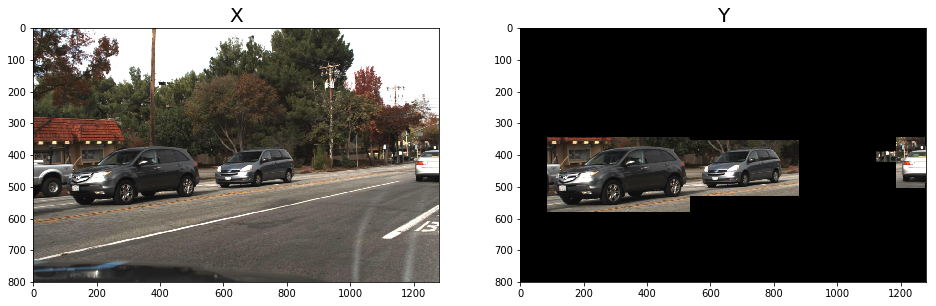

In [10]:
from random import randint
from sklearn.model_selection import train_test_split

#shuffle the dataframe
dfcar_shuffle = dfcar.sample(frac=1).reset_index(drop=True)

def generator(df, batch_size=1):
    while 1:
        x_sample = []
        y_sample = []
        for i in range(batch_size):
            item = randint(0,df.shape[0]-1)
            row = df.iloc[item]
            img_path= row["img"]
            x = mpimg.imread(img_path)
            y = get_segment(x, get_boxes(img_path, df))
            x = cv2.resize(x, (1280, 800), interpolation=cv2.INTER_AREA)
            y = cv2.resize(y, (1280, 800), interpolation=cv2.INTER_AREA)
            y = y[:, :, np.newaxis]
            x_sample.append(x)
            y_sample.append(y)
        yield np.stack(x_sample), np.stack(y_sample)
        

g = generator(dfcar_shuffle)

x, y = next(g)
index = 0
print(x.shape, y.shape)
print(x[index].shape, y[index].shape)

z = x[index].copy()
z[y[index].squeeze()==0]=0
plot_xy(x[index], z)


In [130]:
train_generator = generator(dfcar)
history = model.fit_generator(train_generator, steps_per_epoch=500, epochs=400, verbose=2)

Epoch 1/400
345s - loss: -8.6883e-01 - dice_coef: 0.8688
Epoch 2/400
345s - loss: -8.7161e-01 - dice_coef: 0.8716
Epoch 3/400
350s - loss: -8.6747e-01 - dice_coef: 0.8675
Epoch 4/400
339s - loss: -8.6906e-01 - dice_coef: 0.8691
Epoch 5/400
338s - loss: -8.6978e-01 - dice_coef: 0.8698
Epoch 6/400
338s - loss: -8.6882e-01 - dice_coef: 0.8688
Epoch 7/400
338s - loss: -8.6726e-01 - dice_coef: 0.8673
Epoch 8/400
338s - loss: -8.6195e-01 - dice_coef: 0.8620
Epoch 9/400
338s - loss: -8.6513e-01 - dice_coef: 0.8651
Epoch 10/400
338s - loss: -8.7682e-01 - dice_coef: 0.8768
Epoch 11/400
338s - loss: -8.7121e-01 - dice_coef: 0.8712
Epoch 12/400
338s - loss: -8.7116e-01 - dice_coef: 0.8712
Epoch 13/400
338s - loss: -8.6610e-01 - dice_coef: 0.8661
Epoch 14/400
337s - loss: -8.7980e-01 - dice_coef: 0.8798
Epoch 15/400
336s - loss: -8.7447e-01 - dice_coef: 0.8745
Epoch 16/400
336s - loss: -8.6968e-01 - dice_coef: 0.8697
Epoch 17/400
336s - loss: -8.7270e-01 - dice_coef: 0.8727
Epoch 18/400
336s - los

KeyboardInterrupt: 

In [131]:
### Save weights 
model.save("UNet.h5")
model.save_weights("UNet_weights.h5", overwrite=True)

In [118]:
model.load_weights("UNet_weights.h5")

In [19]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model IOU loss')
plt.ylabel('IOU loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

CPU times: user 64 ms, sys: 4 ms, total: 68 ms
Wall time: 216 ms
(800, 1280, 1)


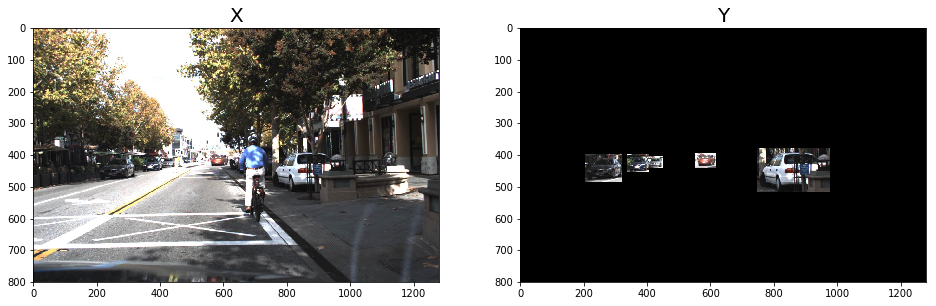

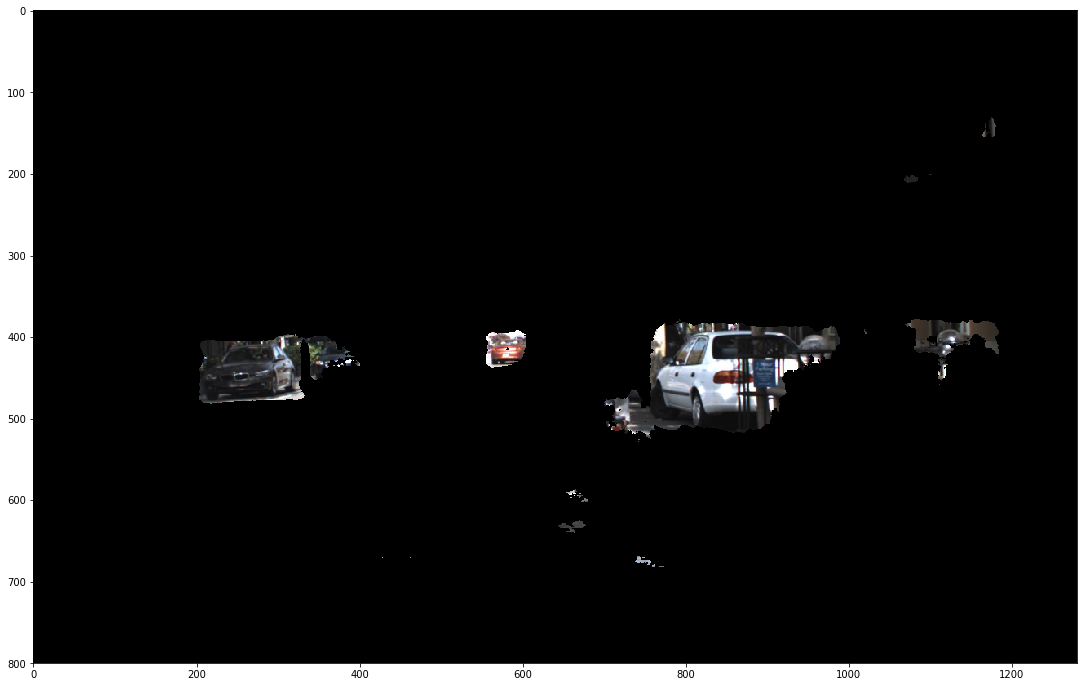

In [152]:
g = generator(dfcar)
x, y = next(g)
index = 0
test_img = x[index]
test_img = cv2.resize(test_img, (1280, 800), interpolation=cv2.INTER_AREA)
test_img = test_img[None, :, :, :]

z = x[index].copy()
z[y[index].squeeze()==0]=0
plot_xy(x[index], z)

%time prediction = model.predict(test_img)[0]
z = test_img.squeeze().copy()
# z = cv2.bitwise_and(z, z, mask=prediction)
z[prediction.squeeze()<0.9]=0
print(prediction.shape)

figure = plt.figure(figsize=(20,12))
plt.imshow(z)

(800, 1280, 1)
(800, 1280)


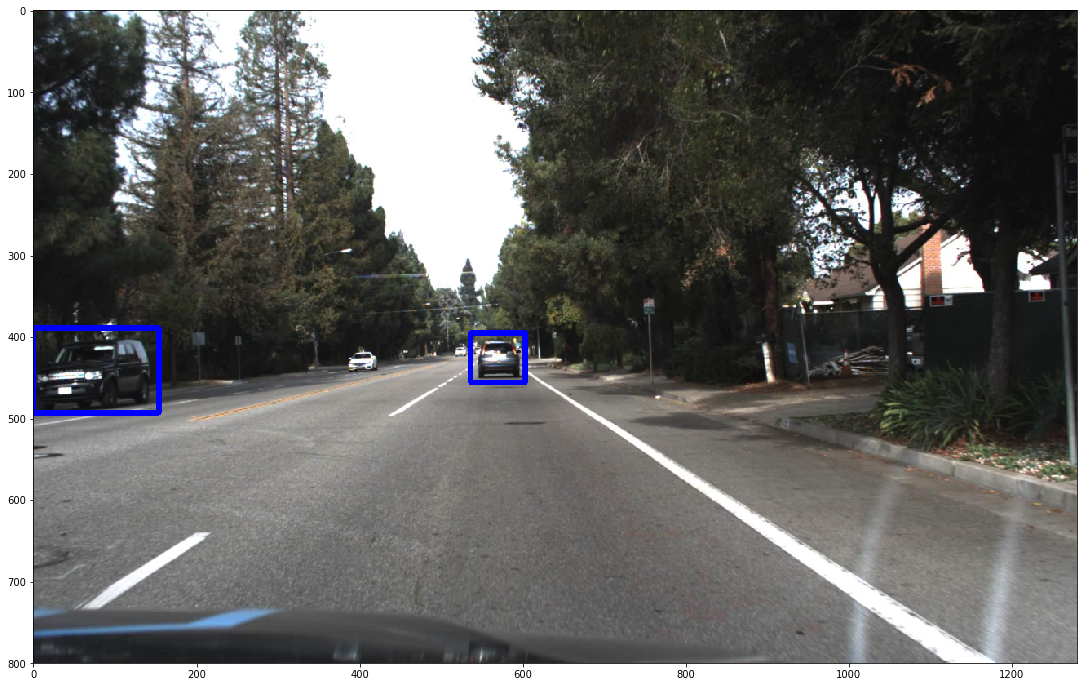

In [82]:
print(prediction.shape)

labels = label(prediction[:,:,0])
print(labels[0].shape)
img = x[index]
# img = cv2.resize(test_img, (1280, 800), interpolation=cv2.INTER_AREA)
for object_no in range(1, labels[1]+1):
    # Find pixels with each car_number label value
    nonzero = (labels[0] == object_no).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)


figure = plt.figure(figsize=(20,12))
plt.imshow(img, cmap='gray')



CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 206 ms
(800, 1280, 1)


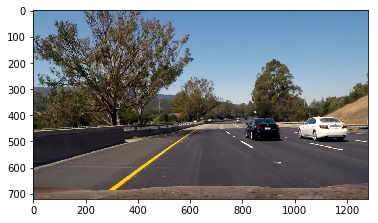

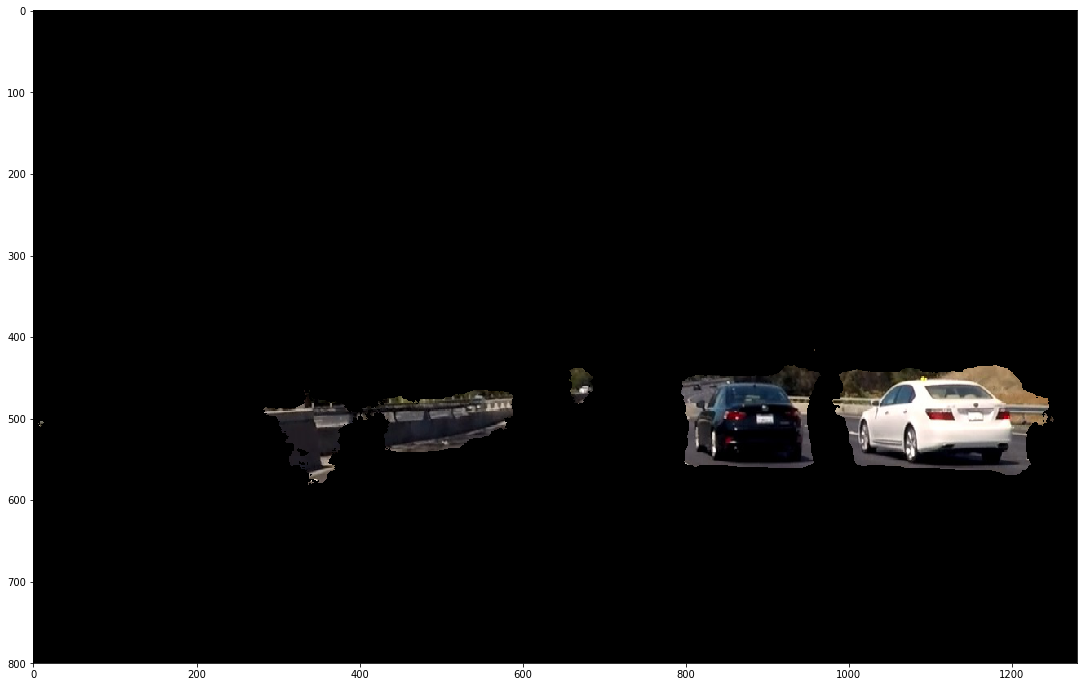

In [96]:
test_img = mpimg.imread("./test_images/test6.jpg")
plt.imshow(test_img)
test_img = cv2.resize(test_img, (1280, 800), interpolation=cv2.INTER_AREA)
test_img = test_img[None, :, :, :]

%time prediction = model.predict(test_img)[0]
z = test_img.squeeze().copy()
# z = cv2.bitwise_and(z, z, mask=prediction)
z[prediction.squeeze()<0.9]=0
print(prediction.shape)


figure = plt.figure(figsize=(20,12))
plt.imshow(z)